Copyright **`(c)`** 2021 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see 'LICENCE.md' for details.

In [1]:
from math import sqrt
from typing import Any
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
class Tsp:

    def __init__(self, num_cities: int, seed: Any = None) -> None:
        if seed is None:
            seed = num_cities
        self._num_cities = num_cities
        self._graph = nx.DiGraph()
        np.random.seed(seed)
        for c in range(num_cities):
            self._graph.add_node(c, pos=(np.random.random(), np.random.random()))

    def distance(self, n1, n2) -> int:
        pos1 = self._graph.nodes[n1]['pos']
        pos2 = self._graph.nodes[n2]['pos']
        return round(1_000_000 / self._num_cities * sqrt((pos1[0] - pos2[0])**2 +
                                                         (pos1[1] - pos2[1])**2))

    def evaluate_solution(self, solution: np.array) -> float:
        total_cost = 0
        tmp = solution.tolist() + [solution[0]]
        for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
            total_cost += self.distance(n1, n2)
        return total_cost

    def plot(self, path: np.array = None) -> None:
        if path is not None:
            self._graph.remove_edges_from(list(self._graph.edges))
            tmp = path.tolist() + [path[0]]
            for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
                self._graph.add_edge(n1, n2)
        plt.figure(figsize=(12, 5))
        nx.draw(self._graph,
                pos=nx.get_node_attributes(self._graph, 'pos'),
                with_labels=True,
                node_color='pink')
        if path is not None:
            plt.title(f"Current path: {self.evaluate_solution(path):,}")
        plt.show()

    @property
    def graph(self) -> nx.digraph:
        return self._graph

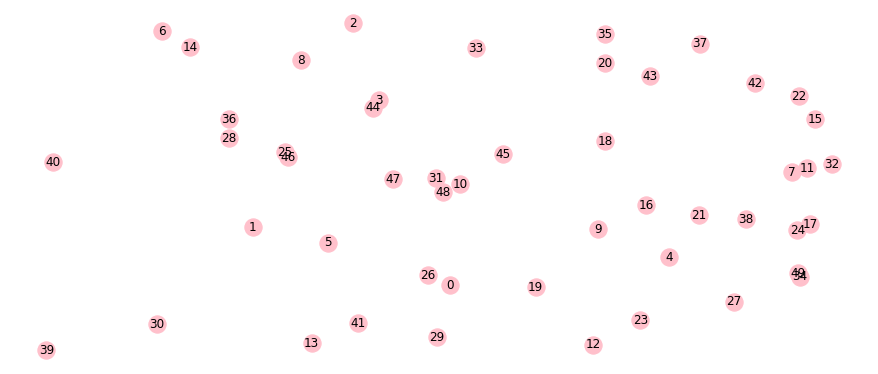

In [86]:
NUM_CITIES = 50

problem = Tsp(NUM_CITIES)
problem.plot()

In [87]:
def mutation(solution: np.array) -> np.array:
    new_solution = solution.copy()
    i1 = np.random.randint(0, NUM_CITIES)
    i2 = np.random.randint(0, NUM_CITIES)
    temp = new_solution[i1]
    new_solution[i1] = new_solution[i2]
    new_solution[i2] = temp
    return new_solution

def scramble_mutation(solution: np.array, ps) -> np.array:
    strength=None
    while strength is None or strength<2:
        strength=np.random.randint(0,100,size=NUM_CITIES)
        strength=(strength < (ps*100)).sum();
    l=np.random.choice(NUM_CITIES,size=strength,replace=False)
    l_val=solution[l]
    np.random.shuffle(l_val)
    new_solution=solution.copy()
    new_solution[l]=l_val
    return new_solution
    
    

def split(solution: np.array) -> np.array:
    #used to try to exploit the solution space
    l=np.random.randint(0, NUM_CITIES)
    split1=np.array(solution[0:l])
    split2=np.array(solution[l:])
    new_solution=np.concatenate((split2,split1))
    return new_solution

def insert_mutation(solution: np.array) -> np.array:
    l1=NUM_CITIES
    while l1>= NUM_CITIES-1:
        l1=np.random.randint(0, NUM_CITIES)
    l2=l1
    while l2==l1 or l2==l1+1 or l1==l2+1:
        l2=np.random.randint(0, NUM_CITIES)
    if l1>l2:
        temp=l1
        l1=l2
        l2=temp
    split1=solution[0:l1]
    split2=solution[l1+1:l2]
    split3=np.array(solution[l2+1:])
    split_ins=np.array((solution[l1],solution[l2]))
    new_solution=np.concatenate((split1,split_ins,split2,split3))
    return new_solution

def inverse_mutation(solution: np.array) -> np.array:
    l1=NUM_CITIES
    while l1>= NUM_CITIES-1:
        l1=np.random.randint(0, NUM_CITIES)
    l2=l1
    while l2==l1 or l2==l1+1 or l1==l2+1:
        l2=np.random.randint(0, NUM_CITIES)
    if l1>l2:
        temp=l1
        l1=l2
        l2=temp
    split1=np.array(solution[0:l1])
    split_inv=np.array(solution[l1:l2])
    split2=np.array(solution[l2:])
    split_inv=np.flip(split_inv)
    new_solution=np.concatenate((split1,split_inv,split2))
    return new_solution

def tweak(solution: np.array, *, pm: float = 1/NUM_CITIES, pme: float = 1/NUM_CITIES) -> np.array:
    modify=0
    new_solution=solution
    p = np.random.random()
    while modify==0:
        while p < pm:
            new_solution=mutation(new_solution)
            p = np.random.random()
            modify+=1
        p=np.random.random()
        while p<pme:
            new_solution=split(new_solution)
            p=np.random.random()
            modify+=1
        p=np.random.random()
        while p<pme:
            new_solution=inverse_mutation(new_solution)
            p=np.random.random()
            modify+=1
        p=np.random.random()
        while p < pm:
            new_solution=insert_mutation(new_solution)
            p=np.random.random()
            modify+=1
        p=np.random.random()
        while p < pm:
            new_solution=scramble_mutation(new_solution,1/((1-pme)*NUM_CITIES))
            p=np.random.random()
            modify+=1
    return new_solution

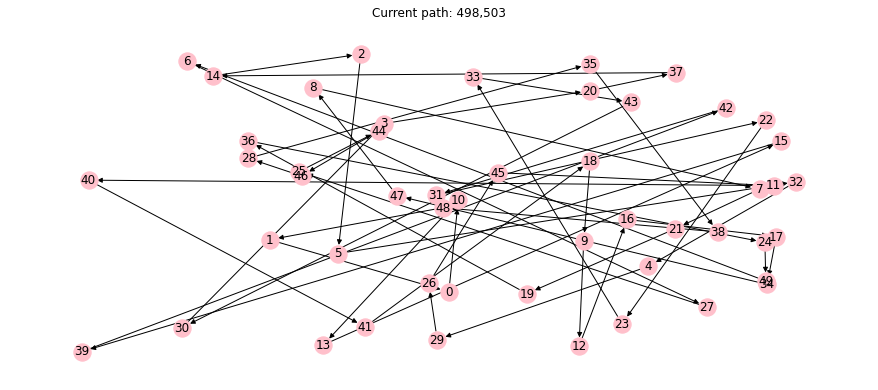

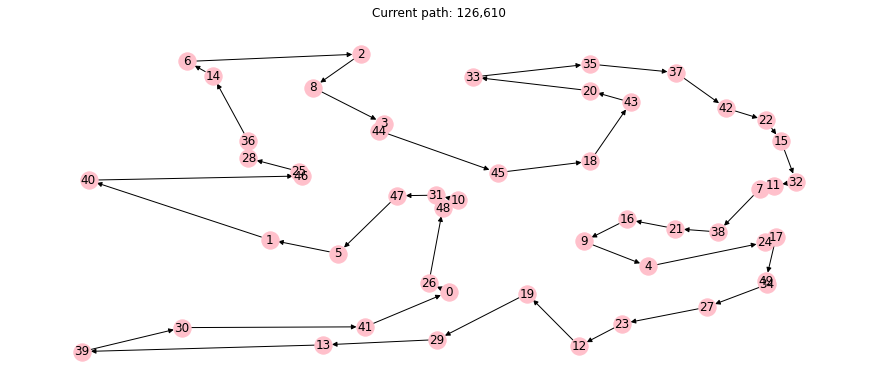

times exploit_state was exceeded: 5


In [89]:
MULTIPLIER=100
MAX_STATE = 5000 #to avoid 
STEADY_STATE = NUM_CITIES*MULTIPLIER
EXPLOIT_STATE = NUM_CITIES*MULTIPLIER
if STEADY_STATE > MAX_STATE:
    STEADY_STATE = MAX_STATE
    EXPLOIT_STATE = MAX_STATE
#not fast for a big number of cities, but usefull to get good result even with lots of cities

solution = np.array(range(NUM_CITIES))
np.random.shuffle(solution)
solution_cost = problem.evaluate_solution(solution)
problem.plot(solution)

history = [(0, solution_cost)]
expoit_n=0
steady_state = 0
step = 0
pm=.1
pme=.01
pmetmp=pm
while steady_state < STEADY_STATE+EXPLOIT_STATE:
    step += 1
    steady_state += 1
    if(steady_state==EXPLOIT_STATE):
        pmetmp=pme #low climb
        expoit_n+=1   
    new_solution = tweak(solution, pm=.5, pme=pmetmp)
    new_solution_cost = problem.evaluate_solution(new_solution)
    if new_solution_cost < solution_cost:
        solution = new_solution
        solution_cost = new_solution_cost
        history.append((step, solution_cost))
        steady_state = 0
        pmetmp=pm
problem.plot(solution)
print("times exploit_state was exceeded: %d"%(expoit_n))